In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('my_app').getOrCreate()
df=spark.read.csv('/content/ML_hw_dataset.csv',header=True,inferSchema=True)
df.show()

+---+-----------+--------+-----------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job| marital|        education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+-----------+--------+-----------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 44|blue-collar| married|         basic.4y|unknown|    yes|  no| cellular|  aug|        thu|     210|       1|  999|       0|nonexistent|         1.4|        93.444|        -36.1|    4.963|     5228.1|  0|
| 53| technician| married|          unknown|     no|     no|  no| cellular|  nov|        fri|     138|       1|  999|       0|nonexistent|        -0.1|          93.2|      

In [3]:
df.describe().show()

+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+-----------------+------------------+------------------+-------------------+--------+-------------------+------------------+------------------+------------------+-----------------+-------------------+
|summary|               age|    job| marital|education|default|housing| loan|  contact|month|day_of_week|         duration|          campaign|             pdays|           previous|poutcome|       emp_var_rate|    cons_price_idx|     cons_conf_idx|         euribor3m|      nr_employed|                  y|
+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+-----------------+------------------+------------------+-------------------+--------+-------------------+------------------+------------------+------------------+-----------------+-------------------+
|  count|             41188|  41188|   41188|    41188|  41188|  41188|41188|    4

In [4]:
from pyspark.sql.functions import isnan,when,count,col
df.select([count(when(isnan(i)|col(i).isNull(),i)).alias(i) for i in df.columns]).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+



In [5]:
from pyspark.ml.feature import StringIndexer
indexer=StringIndexer(inputCol='',outputCol='indexed')
string_cols = [col_name for col_name, col_type in df.dtypes if col_type == "string"]
#for col in string_cols:
out_cols = [c+'_index' for c in string_cols]
indexer = StringIndexer(inputCols=string_cols, outputCols=out_cols)
df=indexer.fit(df).transform(df)
df = df.drop(*string_cols)
df.show()

+---+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+
|age|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|
+---+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+
| 44|     210|       1|  999|       0|         1.4|        93.444|        -36.1|    4.963|     5228.1|  0|      1.0|          0.0|            4.0|          1.0|          0.0|       0.0|          0.0|        2.0|              0.0|           0.0|
| 53|     138|      

In [6]:
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.feature import VectorAssembler,StandardScaler,MinMaxScaler

spark = SparkSession.builder.appName("Normalization").getOrCreate()

numeric_cols = [col for col, dtype in df.dtypes if dtype == "int" or dtype == "double"]
df_numeric = df.select(numeric_cols)

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_numeric_assembled = assembler.transform(df_numeric).select("features")

scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_numeric_assembled)
df_normalized = scaler_model.transform(df_numeric_assembled)

df_normalized = df_normalized.withColumn("id", monotonically_increasing_id())
df = df.withColumn("id", monotonically_increasing_id())

df_normalized = df_normalized.join(df, "id", "outer").drop(df_normalized["id"])
df_normalized.show(10)

+---+--------------------+--------------------+---+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+
| id|            features|     scaled_features|age|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|
+---+--------------------+--------------------+---+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+
|  0|[44.0,210.0,1.0,9...|(21,[0,1,3,5,6,7,...| 44|     210|       1|  999|       0|         1.4|        93.444|        -36.1| 

+---+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+
|age|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|
+---+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+
| 44|     210|       1|  999|       0|         1.4|        93.444|        -36.1|    4.963|     5228.1|  0|      1.0|          0.0|            4.0|          1.0|          0.0|       0.0|          0.0|        2.0|              0.0|           0.0|
| 53|     138|      

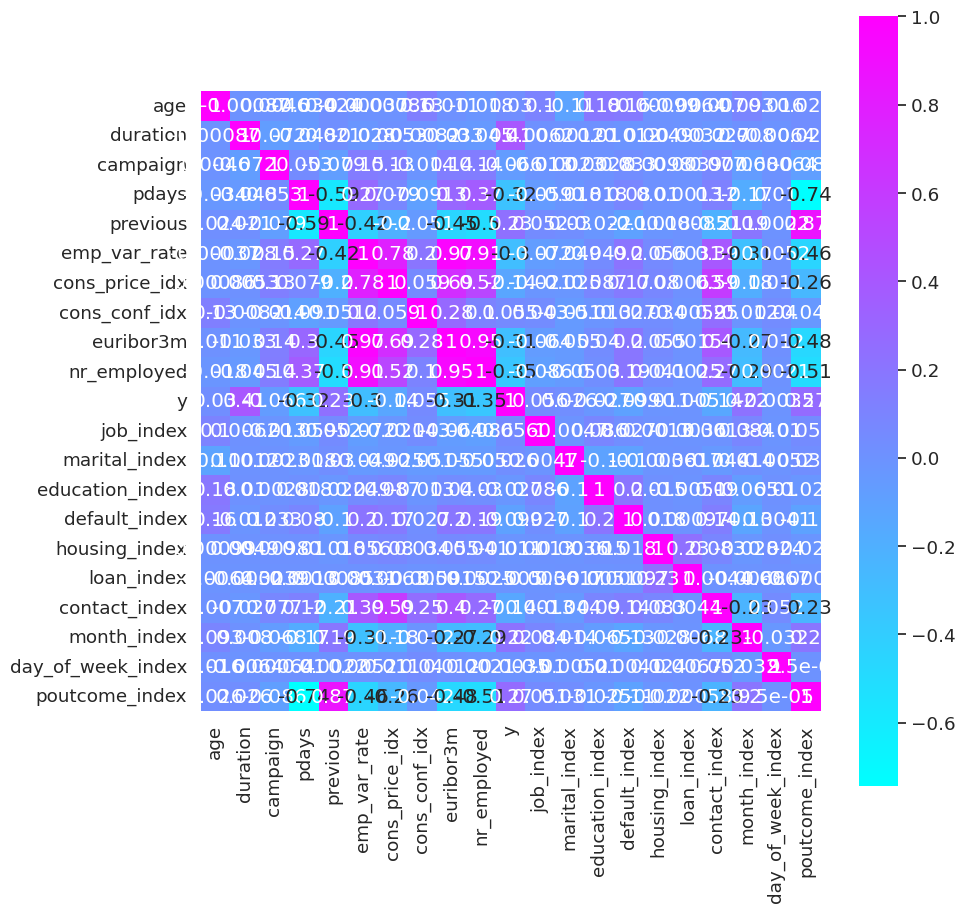

In [7]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = [c for c,d in df.dtypes if d in ['int','double']]
df.select(numeric_cols).show()
assembler = VectorAssembler(inputCols=numeric_cols, outputCol='features')
assembled_data = assembler.transform(df).select('features')

correlation_matrix = Correlation.corr(assembled_data, 'features').head()
corr_array = correlation_matrix[0].toArray()

col_names = [c for c in numeric_cols]

sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_array, cmap='cool', annot=True, square=True, xticklabels=col_names, yticklabels=col_names, ax=ax)

plt.show()

In [8]:
# گام دوم استاندارد سازی داده ها
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
numeric_cols = [col_name for col_name, col_type in df.dtypes if col_type != 'string' and col_name != "y"]
assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol='features')

proccess_df = assembler.transform(df).select("features","y")
from pyspark.ml.feature import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Fit the scaler to the data and transform
scaledData = scaler.fit(proccess_df).transform(proccess_df)
#df = model.transform(proccess_df).select("scaledFeatures","y")

In [9]:
#گام دوم pca و کاهش ابعاد
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
numeric_cols = [col_name for col_name, col_type in df.dtypes if col_type != 'string' and col_name != "y"]

assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol='features')

proccess_df = assembler.transform(df)
k = 10

pca = PCA(k=k, inputCol="features", outputCol="pcafeatures")

model = pca.fit(proccess_df)
df = model.transform(proccess_df).select("pcafeatures","y")

df.show(1,truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|pcafeatures                                                                                                                                                                                   |y  |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|[-5.581101386108166E-7,34.24030726503225,1840.7932224616363,-4995.54692692322,44.337633673142186,98.51685852183734,-33.71618515763822,18.728896174724113,42.22413728058581,-9.455035249393859]|0  |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
only showing to

In [10]:
from pyspark.sql.functions import corr
df_normalized.select([corr('age', 'y').alias('corr_age_y'),
           corr('pdays', 'y').alias('corr_pdays_y'),
           corr('emp_var_rate', 'y').alias('corr_emp_var_rate_y'),
           corr('cons_price_idx', 'y').alias('corr_cons_price_idx_y'),
           corr('cons_conf_idx', 'y').alias('corr_cons_conf_idx_y'),
           corr('euribor3m', 'y').alias('corr_euribor3m_y'),
           corr('job_index', 'y').alias('corr_job_index_y'),
           corr('marital_index', 'y').alias('corr_marital_index_y'),
           corr('education_index', 'y').alias('corr_education_index_y'),
           corr('default_index', 'y').alias('corr_default_index_y'),
           corr('housing_index', 'y').alias('corr_housing_index_y'),
           corr('contact_index', 'y').alias('corr_contact_index_y'),
           corr('month_index', 'y').alias('corr_month_index_y'),
           corr('day_of_week_index', 'y').alias('corr_day_of_week_index_y'),
           corr('poutcome_index', 'y').alias('corr_dpoutcome_index_y')])

DataFrame[corr_age_y: double, corr_pdays_y: double, corr_emp_var_rate_y: double, corr_cons_price_idx_y: double, corr_cons_conf_idx_y: double, corr_euribor3m_y: double, corr_job_index_y: double, corr_marital_index_y: double, corr_education_index_y: double, corr_default_index_y: double, corr_housing_index_y: double, corr_contact_index_y: double, corr_month_index_y: double, corr_day_of_week_index_y: double, corr_dpoutcome_index_y: double]

In [11]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train_data, test_data = df.randomSplit([0.8, 0.2], seed=100)

svm = LinearSVC(featuresCol="pcafeatures", labelCol="y")
svm_model = svm.fit(train_data)
predictions = svm_model.transform(test_data)

lr = LogisticRegression(labelCol='y', featuresCol='pcafeatures')
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)


In [12]:
print('svm_recall:',svm_model.evaluate(test_data).recallByLabel)
print('logisticregression_recall: ',lr_model.evaluate(test_data).recallByLabel)

svm_recall: [0.9817583321903717, 0.2109795479009688]
logisticregression_recall:  [0.9739404745576739, 0.379978471474704]


In [13]:
print('svm_accuracy:',svm_model.evaluate(test_data).accuracy)
print('logisticregression_accuracya',lr_model.evaluate(test_data).accuracy)

svm_accuracy: 0.8946472019464721
logisticregression_accuracya 0.9068126520681266


In [14]:
print('svm_precision:',svm_model.evaluate(test_data).precisionByLabel)
print('logisticregression_precision',lr_model.evaluate(test_data).precisionByLabel)

svm_precision: [0.9071093650994804, 0.5957446808510638]
logisticregression_precision [0.9249706916764361, 0.6500920810313076]
